In [13]:
%matplotlib inline


# Scientific Computation Lab 7 solution







## Task 1: Numerical solution of an initial value problem (again)

In Lab 6, you used *solve_ivp* from scipy.integrate to solve an IVP. Now, you will use an alternate approach to solve the following problem:

$\frac{dy_1}{dt} =   y_2 $

$\frac{dy_2}{dt} =  -y_1 $

$y_1(0)=1, ~ y_2(0)=0$


1) We can rewrite these equations in matrix form: $\frac{d \mathbf{y}}{dt} = A \mathbf{y}$ and solve the problem above using the *matrix exponential*: $\mathbf{y}(t) = exp(At)\mathbf{y}_0$. Use this method below, and compare your solution to the analytical result. (The matrix exponential is distinct from element-by-element exponentiation using np.exp)

In [14]:
import numpy as np
import scipy.linalg

w = 1
y0=[1,0]
t=1
A = np.array([[0,1],[-1,0]])
y = np.dot(scipy.linalg.expm(A*t),y0)
print("y=",y)
yexact = np.cos(w*t),-w*np.sin(w*t)
print("yexact=",yexact)

y= [ 0.54030231 -0.84147098]
yexact= (0.5403023058681398, -0.8414709848078965)


2) Investigate how the cost of the matrix exponential depends on the matrix size using timing tests

N= 10
N= 20
N= 40
N= 100
N= 200
N= 400
N= 1000
N= 2000


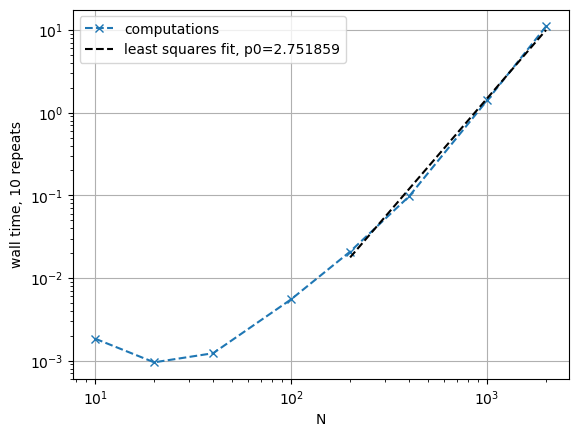

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

Nvalues = [10,20,40,100,200,400,1000,2000]
Nvalues = np.array(Nvalues)
repeats = 10
dt_list = []
for N in Nvalues:
    print("N=",N)
    A = np.random.rand(N,N)
    t1 = time()
    for i in range(repeats):
        E = scipy.linalg.expm(A)
    t2 = time()
    dt_list.append(t2-t1)
    
    
dta = np.array(dt_list)
plt.figure()
plt.loglog(Nvalues,dta,'x--',label='computations')
plt.grid()
plt.xlabel('N')
plt.ylabel('wall time, %d repeats'%(repeats))

p = np.polyfit(np.log(Nvalues[-4:]),np.log(dta[-4:]),1)
plt.plot(Nvalues[-4:],np.exp(p[1])*Nvalues[-4:]**p[0],'k--',label='least squares fit, p0=%f'%(p[0]))
plt.legend()


For $N<100$ we don't see a clear trend, probably due to the cost of managing the input/output being comparable to the cost of the actual matrix exponential calculation. But for larger $N$, we see something like $\sim N^{2.7}$ cost

## Task 2: Dimension reduction with PCA

In this lab, you will use PCA to analyze the well-known Iris dataset: *The dataset consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters.*

We will use PCA to reduce the dimension of the dataset to three variables which should "separate" the three species.

Running the code below will import necessary libraries and read in the data set.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data.T
y = iris.target

1) What are the shapes of X and y? How does y assign labels to the 3 species?

In [2]:
M,N = np.shape(X)
print("M,N=",M,N)

M,N= 4 150


2) Now, create a new matrix $A$ which corresponds to $X$ with the mean of each row removed 

In [18]:
A = np.transpose(X.T-X.mean(axis=1))
np.mean(A,axis=1)

array([-1.12502600e-15, -7.60872846e-16, -2.55203266e-15, -4.48530102e-16])

In the 2nd line above, we are relying on the rules of numpy broadcasting for carrying out arithmetic between arrays of different sizes. See [here](https://cs231n.github.io/python-numpy-tutorial/#broadcasting) for more information

3) Compute the SVD of $A$. What is its rank?

In [19]:
U,S,WT = np.linalg.svd(A)
print("rank(A):",S[S>1e-11].size)

rank(A): 4


4) Now, apply PCA to $A$ and create the transformed data matrix $\tilde A=U^TA$

In [20]:
Atilde = np.dot(U.T,A)
print(A.shape,U.shape,Atilde.shape)


(4, 150) (4, 4) (4, 150)


5) The four rows of $\tilde A$ are the data represented in terms of four "new" variables which are linear combinations of the orginal four features. Verify that there is zero covariance for each pair of the new variables, and that the total variance of the transformed data matches the total variance of the initial data 

In [21]:
m,n = M,N
Cov = 1/(n-1)*Atilde.dot(Atilde.T)
var_tot_new = Cov.trace()
var_tot_old = 1/(n-1)*np.trace(A.dot(A.T))
print("new total variance=",var_tot_new)
print("old total variance",var_tot_old)

#set diagonal terms in Cov to zero and check that all other terms are zero
Cov = Cov - np.diag(Cov)*np.eye(m)
print("Maximum covariance=",np.max(np.abs(Cov)))

new total variance= 4.572957046979866
old total variance 4.572957046979866
Maximum covariance= 1.7882786973828024e-16


6) We will now discard the fourth new variable. Is this justified?

In [22]:
print("Variance of new variables:", 1/(n-1)*S**2)

Variance of new variables: [4.22824171 0.24267075 0.0782095  0.02383509]


The "3rd" new variable has about 3 times the variance of the 4th, which provides some justification for removing the 4th variable (it would be better if the difference was larger)

7) Does the first new variable distinguish between the three species? Make a plot visualizing the values of this variable for each species. 

Text(0, 0.5, 'species label')

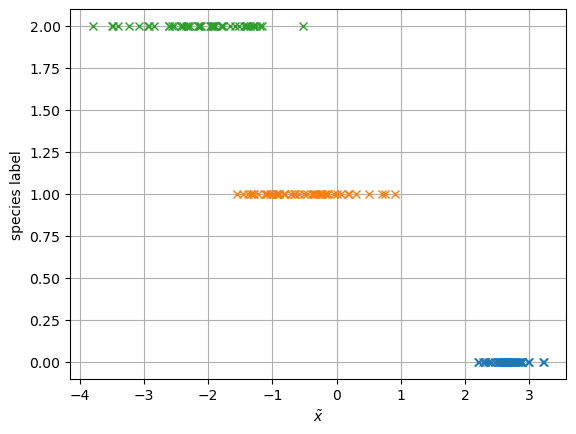

In [23]:
plt.figure()
for i in [0,50,100]:
    plt.plot(Atilde[0,i:i+50],y[i:i+50],'x')
plt.grid()
plt.xlabel(r'$\tilde{x}$')
plt.ylabel('species label')

8) The first 3 rows of $\tilde A$ are our reduced-dimension representation of the data (in the new variables). The cell below will plot the these rows on a 3d plot (each column of $\tilde A$ contains the coordinate for an individual plant) with the point colors corresponding to plant species. You should be able to see a clear "separation" of the three Iris species. This reduced data could then be provided to a clustering algorithm which would assign labels (0,1, or 2) to each of the 150 plants.

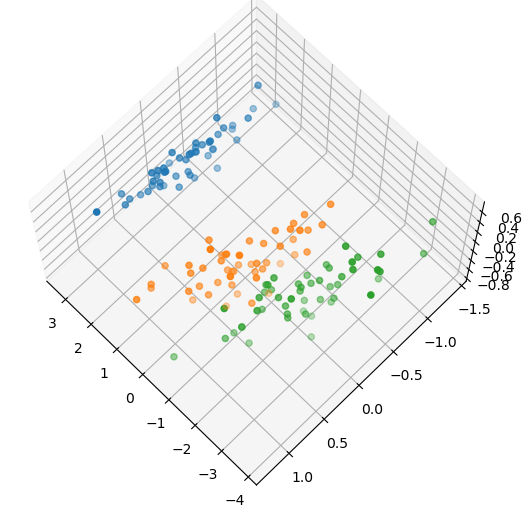

In [24]:
fig = plt.figure()
ax = Axes3D(fig, elev=70, azim=135, auto_add_to_figure=False)
fig.add_axes(ax)
for i in [0,50,100]:
    ax.scatter(Atilde[0,i:i+50],Atilde[1,i:i+50],Atilde[2,i:i+50])
plt.show()